In [2]:
# Необходимые библиотеки
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [4]:
# Чтение Parquet-файлов
train_url = 'data/hackaton_train_types_recom.parquet'
test_url = 'data/hackaton_test_types_recom.parquet'

train = pd.read_parquet(train_url, engine="pyarrow")
test = pd.read_parquet(test_url, engine="pyarrow")

print(f"Train данные(строк и колонок): {train.shape}, Test данные(строк и колонок): {test.shape}")

# объединяем все в одно для предобработки и разделения
df = pd.concat([train, test], axis=0)  # axis=0 — объединяем по строкам

print(f"\nОбъединенные данные (строк и колонок): {df.shape}\n")

print("\nКолонки:\n", df.columns.tolist())
print("\nПропуски:\n", df.isnull().sum())
print("\nДубликатов:\n", df.duplicated().sum())

Train данные(строк и колонок): (763013, 8), Test данные(строк и колонок): (190754, 8)

Объединенные данные (строк и колонок): (953767, 8)


Колонки:
 ['main_photo', 'name', 'type', 'category_l2', 'category_l4', 'is_markup', 'target', 'stratify_column']

Пропуски:
 main_photo              0
name                    0
type                    0
category_l2        400757
category_l4        400757
is_markup               0
target                  0
stratify_column         0
dtype: int64

Дубликатов:
 66888


#### Пропуски
> В колонках `category_l2` и `category_l4` пропущено **~42%** данных (400,757 из 953,767). Это критично, так как категории — важный признак для рекомендаций.

**Варианты решения:**
- Заполнить пропуски значением `"Unknown"` и выделить в отдельную категорию.
- Использовать другие признаки (например, `name` или `main_photo`) для предсказания категорий.

---

#### Дубликаты
> В объединенном наборе данных найдено **66,888** дубликатов.

**Варианты решения:**
- Удалить дубликаты, чтобы избежать смещения модели и переобучения.


In [5]:
# Распределение target
target_dist = df["target"].value_counts(normalize=True)
print("\nРаспределение target:\n", target_dist)


Распределение target:
 target
1    0.503145
0    0.496855
Name: proportion, dtype: float64


#### Баланс классов почти идеальный:

50.3% — target=1 (тип подходит), 49.7% — target=0 (тип не подходит).

**Вывод**: Нет дисбаланса, однако могут быть скрытые смещения (например, для некоторых категорий товаров распределение сильно отличается)

In [26]:
# Распределение target по категориям
category_target = df.groupby("category_l2")["target"].mean().sort_values(ascending=False)
print("\nДоля подходящих типов (target=1) по категориям:\n", category_target.head(10))

category_target = df.groupby("category_l2")["target"].mean().sort_values(ascending=True)
print("\nДоля подходящих типов (target=1) по категориям:\n", category_target.head(10))

category_target = df.groupby("category_l4")["target"].mean()
print("\nДоля подходящих типов (target=1) по категориям:\n", category_target.head(10))


Доля подходящих типов (target=1) по категориям:
 category_l2
Книги                            0.991828
Ювелирные изделия                0.987322
Мебель                           0.878284
Галантерея и аксессуары          0.853501
Кино, музыка, видеоигры, софт    0.829714
Дом и сад                        0.793193
Обувь                            0.728272
Одежда                           0.706272
Строительство и ремонт           0.691614
Продукты питания Ozon Fresh      0.677132
Name: target, dtype: float64

Доля подходящих типов (target=1) по категориям:
 category_l2
Бытовая химия                       0.308873
Антиквариат и коллекционирование    0.331516
Музыкальные инструменты             0.340191
Аптека                              0.341457
Продукты питания                    0.373853
Красота и гигиена                   0.374317
Автомототехника                     0.399340
Хобби и творчество                  0.429578
Детские товары                      0.438568
Бытовая техника       

#### Выводы по анализу категорий
**1. Категории — ключевой фактор для предсказания**
Анализ показал, что категория товара является одним из самых сильных предикторов для target.

Высокоуровневые категории (category_l2) сильно коррелируют с результатом.

Высокая вероятность (target=1): Книги (99.2%), Ювелирные изделия (98.7%).

Низкая вероятность (target=1): Бытовая химия (30.9%), Антиквариат (33.2%), Аптека (34.1%).

Детализированные подкатегории (category_l4) еще более информативны.

Наблюдается большая вариативность даже внутри одной категории. Например, для 3D-товаров: 3D-принтер имеет 100% совпадений, в то время как 3D-пазл — всего 24.8%.

**2. Потенциальные риски и уязвимости**
Риск утечки данных. Модель может научиться предсказывать target только на основе категории, игнорируя другие важные признаки, такие как название или фото.

Риск смещения выборки. Статистика по редким категориям (где 1-2 примера) ненадежна. Требуется их группировка (например, в категорию "Прочее"), чтобы избежать ложных зависимостей.

target
0    62.091375
1    71.159024
Name: name_length, dtype: float64


<Figure size 1000x600 with 0 Axes>

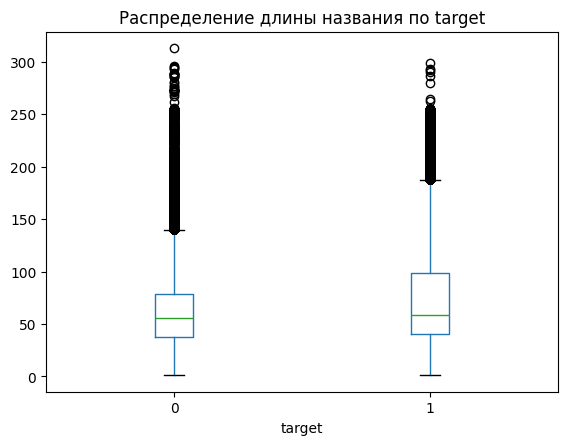

In [27]:
"""Анализ длины названия (name)"""
# Добавим столбец с длиной названия
df['name_length'] = df['name'].apply(lambda x: len(str(x)))

# Сравним среднюю длину названия для target=1 и target=0
print(df.groupby('target')['name_length'].mean())

# Визуализация
plt.figure(figsize=(10, 6))
df.boxplot(column='name_length', by='target', grid=False)
plt.title('Распределение длины названия по target')
plt.suptitle('')
plt.show()

##### Анализ длины названия (name)

Товары с target=1 имеют более длинные названия (в среднем 71.1 символ) по сравнению с target=0 (62.1 символ).
Возможно более длинные названия содержать больше стандартизированных описаний (например, "Картина на холсте для интерьера, 50x70 см").

Короткие названия (target=0) могут быть менее формализованными (например, "Антикварная статуэтка").

**Вариант решения**: Использовать длину названия как признак в модели.

target
0    0.681772
1    0.736129
Name: has_digits, dtype: float64


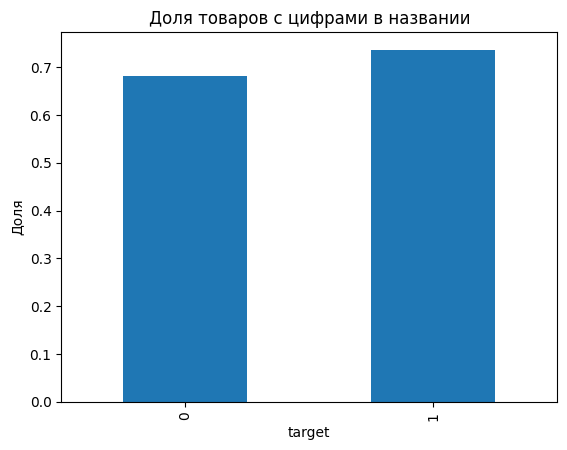

In [18]:
"""Наличие цифр в названии"""
# Добавим признак "содержит цифры"
df['has_digits'] = df['name'].apply(lambda x: any(c.isdigit() for c in str(x)))

# Сравним долю товаров с цифрами в названии
print(df.groupby('target')['has_digits'].mean())

# Визуализация
df['has_digits'].groupby(df['target']).mean().plot(kind='bar')
plt.title('Доля товаров с цифрами в названии')
plt.ylabel('Доля')
plt.show()

#### Наличие цифр в названии

Товары с target=1 чаще содержат цифры (73.6% против 68.2% для target=0).

Цифры могут указывать на артикулы, размеры, год выпуска (например, "Кроссовки Nike Air Force 1, 42 размер").

Зато товары без цифр (target=0) могут быть уникальными (например, "Ручная работа, керамическая ваза").

**Вариант решения**: Добавить бинарный признак про наличие цифр

In [19]:
"""Ключевые слова в названии"""
from collections import Counter

# Функция для извлечения топ-N слов по target
def get_top_words(data, target_value, n=10):
    words = []
    for name in data[data['target'] == target_value]['name']:
        words.extend(str(name).lower().split())
    return Counter(words).most_common(n)

# Топ-10 слов для target=1 и target=0
top_words_target1 = get_top_words(df, 1)
top_words_target0 = get_top_words(df, 0)

print("Топ-10 слов для target=1:", top_words_target1)
print("Топ-10 слов для target=0:", top_words_target0)

Топ-10 слов для target=1: [('для', 194248), ('на', 136910), ('с', 94291), ('и', 67308), ('см.', 62331), ('в', 61006), ('холсте', 32884), ('картина', 31981), ('интерьера', 30577), ('подрамнике', 26021)]
Топ-10 слов для target=0: [('для', 229860), ('с', 68411), ('и', 48435), ('на', 43212), ('в', 27883), ('см', 26070), ('набор', 24631), ('1', 20260), ('-', 20152), ('/', 18870)]


#### Ключевые слова в названии

Для target=1 чаще встречаются:"холсте", "картина", "интерьера", "подрамнике", что указывает на стандартные товары (например, картины, мебель).

Для target=0 чаще встречаются: "набор", "1", "-", "/" — могут быть нестандартными товарами (например, "Набор для вышивания №1").

**Варианты решения**:
- Проверить топ заново после предобработки
- Добавить признаки на основе ключевых слов

is_markup
False    0.594069
True     0.252338
Name: target, dtype: float64


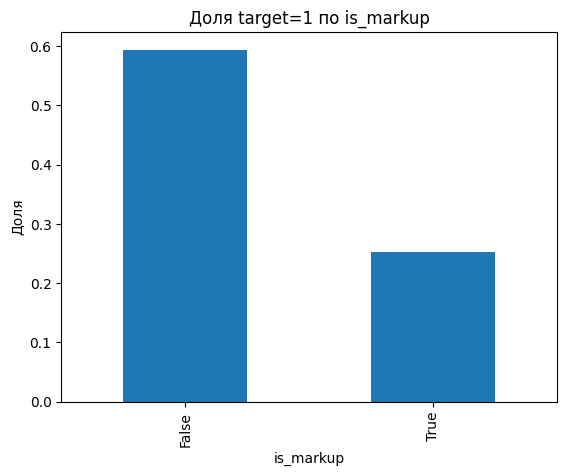

In [20]:
"""Корреляция с is_markup"""
# Доля target=1 для is_markup=0 и is_markup=1
print(df.groupby('is_markup')['target'].mean())

# Визуализация
df.groupby('is_markup')['target'].mean().plot(kind='bar')
plt.title('Доля target=1 по is_markup')
plt.ylabel('Доля')
plt.show()

#### Корреляция с is_markup

Поле is_markup — это метка для "нестандартных" товаров. помогает выделить товары, которые:

- Требуют ручной проверки из-за неочевидного соответствия типу.

- Имеют уникальные атрибуты, не укладывающиеся в стандартные шаблоны.

- Могут быть ошибочно размещены в категориях (как наушники в Аптеке).

**Варианты решения**: использовать как важный бинарный признак, т.к. он явно разделяет товары на "стандартные" и "специальные".

In [21]:
# Уникальность названий
print("\nУникальных названий:\n", df["name"].nunique())


Уникальных названий:
 590915


#### Уникальность названий

Из 953к товаров всех товаров только 590к уникальных названий. Это значит, что у нас много товаров с почти одинаковыми названиями (то ли дубликаты, то ли вариации).

Возможно предобработка (токенизация и удаление стоп-слов) поможет.

In [22]:
# Проверка, есть ли тип товара в его названии (потенциальная утечка)
df["leak_check"] = df.apply(lambda x: str(x["type"]).lower() in str(x["name"]).lower(), axis=1)
print("\nДоля товаров, где тип содержится в названии:\n", df["leak_check"].mean())


Доля товаров, где тип содержится в названии:
 0.2659108566347965


#### Потенциальная утечка

26.57% товаров содержат свой тип прямо в названии. Т.е. в названии товара "Футболка с надписью "Лингвисты Шрёдингера" уже есть название типа "Футболка".

Это создаёт риск data leakage - наша модель может начать "подсматривать" ответы, просто находя type в name, вместо реального обучения, и на валидации мы увидим, что метрики завышены, так как модель "жульничает". А вот с новыми данными, где нет явных совпадений мы отхватим плохое обобщение и как результат некорректные рекомендации для тех товаров, у которых нет явного типа в названии

**Варианты решения**
- Удаление "утекших" примеров

Плюсы: Полностью устраняем утечку

Минусы: Теряем 26% данных → может ухудшить качество

- Маскирование типа в названии

Плюсы: Сохраняем все данные, но убираем подсказки

Минусы: Могут остаться косвенные указания (например, аббревиатуры)

- Разделение на два набора. Обучаем на clean данных (~73%), дальше тестируем на полном наборе и сравниваем метрики на clean/полных данных

In [23]:
# Уникальные типы для target=1 и target=0
types_target1 = set(df[df['target'] == 1]['type'].unique())
types_target0 = set(df[df['target'] == 0]['type'].unique())

print("Количество типов только в target=1:", len(types_target1 - types_target0))
print("Количество типов только в target=0:", len(types_target0 - types_target1))

# Уникальные типы для target=1 и target=0
types_target1 = set(df[df['target'] == 1]['type'].dropna().unique())
types_target0 = set(df[df['target'] == 0]['type'].dropna().unique())

# Типы, которые есть только в target=1 или target=0
unique_to_target1 = list(types_target1 - types_target0)
unique_to_target0 = list(types_target0 - types_target1)

# Функция для вывода списка порциями
def print_chunked(items, title, chunk_size=10):
    print(f"\n{title} (всего {len(items)}):")
    for i in range(0, len(items), chunk_size):
        chunk = items[i:i+chunk_size]
        print(", ".join(f"'{x}'" for x in chunk))

# Вывод результатов порциями
print_chunked(unique_to_target1, "Типы только в target=1")
print_chunked(unique_to_target0, "Типы только в target=0")

Количество типов только в target=1: 304
Количество типов только в target=0: 4557

Типы только в target=1 (всего 304):
'Мини вибратор', 'Трансформатор для СВЧ', 'Перечница винтажная', 'Кнопка/выключатель для холодильника', 'Надувная фигура для пейнтбола', 'Рукоятка рычага КПП/ручного тормоза', 'Травильная паста/гель', 'Свадебный аксессуар', 'Светильник-пушлайт', 'Игла для накачивания мяча'
'Блюдце авторское', 'Сетка для пляжного тенниса', 'Органайзер для резинок, заколок подвесной', 'Вешалка для шлема', 'Сушильный шкаф для одежды', 'Кресло антикварное', 'Запонки винтажные', 'Ходунки, костыли для детей с ДЦП', 'Тату набор', 'Брошюровщик / переплетчик'
'Ершик для колбы', 'Термопресс стоматологический', 'Стерилизатор для ножей', 'Кондиционер для флюид-арта', 'Проволока вязальная', 'Врезная розетка для автомобиля', 'Трансформатор для холодильника', 'Средство для дезинфекции и стерилизации мед. изделий', 'Военный сувенир антикварный', 'Сертификат на аудиокнигу, подкаст'
'Полка/держатель для 

#### Количество типов только в target=1 и в target=0

Тип товара (type) почти всегда определяет, подходит он или нет (target=1 или 0)

304 типа встречаются только в target=1, а 4557 — только в target=0.
Некоторые типы товаров жестко привязаны к целевому значению, это как раз наша утечка, которые мы видим выше. Т.е.если тип "Электронная книга" — почти всегда подходит (target=1),а вот тип "Антикварная игрушка" — почти никогда не подходит (target=0)

Соответственно, модель может просто запомнить эти связи ("увидит тип — сразу даст ответ") и просто будет списывать ответы, а не учиться решать

**Варианты решения**:

- удалить этот столбец совсем (но мы потеряем 26% данных)

- заменить типы на группы (например, "книги", "игрушки" вместо точных названий)
И вместо 5000 разных типов получим, например 20-30 общих групп.

Но тут есть нюанс: как-то проследить, чтобы электронная книга как формат для чтения попала в "Книги", а электронная книга - устройство для чтения попало в "Электронику"

In [24]:
# Топ-10 самых частых категорий category_l2
top_categories = df["category_l2"].value_counts().head(10)
print("\nТоп-10 категорий:\n", top_categories)

# Топ-10 самых частых категорий category_l4
top_categories = df["category_l4"].value_counts().head(10)
print("\nТоп-10 категорий:\n", top_categories)


Топ-10 категорий:
 category_l2
Дом и сад                  106510
Строительство и ремонт      71002
Автотовары                  69001
Одежда                      48705
Электроника                 44444
Галантерея и аксессуары     23181
Мебель                      22421
Обувь                       22195
Детские товары              21650
Красота и гигиена           19935
Name: count, dtype: int64

Топ-10 категорий:
 category_l4
Картина                                    30354
Фотообои                                   22039
Матрас                                     14917
Светильник для дома                        14084
Автофильтры                                13668
Постер                                     11632
Саженец, рассада                            7151
Кроссовки                                   6885
Тормозные колодки дисковые и барабанные     6287
Кружка                                      6017
Name: count, dtype: int64


Самые популярные направления и хиты продаж в категориях потребуют особого внимания при обучении модели.

Возможно, стоит создать отдельные подмодели для топовых категорий.

Товары из этих категорий будут сильно влиять на общие показатели.

In [25]:
display(HTML(df.head(10).to_html()))

,main_photo,name,type,category_l2,category_l4,is_markup,target,stratify_column,name_length,has_digits,leak_check
6762112,https://cdn1.ozone.ru/s3/multimedia-d/6564759805.jpg,Фильтр АКПП HYUNDAI GETZ 02-10/ELANTRA 1.8 00-06/MATRIX 1.6 01-08/KIA RIO 1.4 05-11/CERATO 1.6 04-06,Ремкомплект двигателя мототехники,None,None,False,0,nan_False_0,100,True,False
2248350,https://cdn1.ozone.ru/s3/multimedia-r/6700269015.jpg,"Масло оливковое Urzante Light рафинированное, с добавлением оливкового нерафинированного, 250 мл",Растительное масло,None,None,False,1,nan_False_1,96,True,False
2940012,https://cdn1.ozone.ru/multimedia/1026904772.jpg,Свитшот Reebok Cl A Crew,Оповещатель,None,None,False,0,nan_False_0,24,False,False
7671340,https://cdn1.ozone.ru/s3/multimedia-1-r/7000802343.jpg,Клин съемник для снятия пластика в авто,Съемник,None,None,False,1,nan_False_1,39,False,True
795605,https://cdn1.ozone.ru/s3/multimedia-1-u/7120280262.jpg,HXD Пыльник,Олимпийка,None,None,False,0,nan_False_0,11,False,False
230835,https://cdn1.ozone.ru/s3/multimedia-1-d/7196434393.jpg,Кроссовки Air Jordan JT 2 Баскетбольная обувь Oрганизация 2 Jayson Tatum 2 xiaoye,Моноласта,Обувь,Кроссовки,True,0,Обувь_True_0,81,True,False
934908,https://cdn1.ozone.ru/s3/multimedia-1-o/7257717204.jpg,Подарочный праздничный пакет на День рождения 14 февра,Пакет подарочный,None,None,True,1,nan_True_1,54,True,False
150710,https://cdn1.ozone.ru/s3/multimedia-1-r/7110647919.jpg,Подвесной держатель для медалей,Стеллаж для игрушек,Дом и сад,Ящик для игрушек,True,0,Дом и сад_True_0,31,False,False
559188,https://cdn1.ozone.ru/s3/multimedia-y/6586190962.jpg,Свидетельство о венчании в твердом переплете с тиснением,Сменный блок для когтеточек,None,None,False,0,nan_False_0,56,False,False
6055908,https://cdn1.ozone.ru/s3/multimedia-j/6808504267.jpg,"Силиконовая скатерть прозрачная на стол, клеенка прямоугольная ПВХ 160х120 см",Трость-стул,None,None,False,0,nan_False_0,77,True,False


без названия, видимо, ID товара

main_photo - фото товара

name - название товара

type - тип товара

category_l2 - общие категории (верхний уровень)

category_l4 - узкие подкатегории (нижний уровень)

is_markup	- метка нестандартных товаров

target - бинарная классификация (0 — тип не подходит, 1 — тип подходит)

stratify_column	- стратификация (краткое описание category_l2, is_markup и target)

name_length - длина названия товара

has_digits - наличие цифр в названии

leak_check - есть ли в названии товара название типа